<a href="https://colab.research.google.com/github/Lucy-Moctezuma/Machine-Learning-Projects-for-SFSU/blob/main/E.%20Coli%20Machine%20Learning%20Project/4_Extreme_Gradient_Boosted_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extreme Gradient Boosted Tree**

## ***Objectives for this Notebook***
- Expand concepts learned about tree methods (ensemble methods) into Extreme Gradient Boosted Trees Algorithm.
- Create functions to implement Gradient Boosted Trees into Moragadivand's dataset.

**Extreme Gradient Boosted Tree (XGBoost)** is another ensemble method similar to Random Forests as it also uses several Decision Trees, each tree using a random subset of features and observations. XGBoost can use regressor trees or classifier trees as well. But we will only focus on using it for Classification. Below we have an outline of the main differences between Random Forests and XGBoost Trees.

|<font size=4>Random Forest|<font size=4>XGBoost Tree|
|:---|:---|
|<font size=3>All trees are created as a group and are independent|<font size=3>Trees are created sequentially (one tree at a time) <br> and depend on the previous trees residual outputs|
|<font size=3>Uses **bagging**: *Boostrapping* + *Aggregation* <br> - *Boostrapping:* random sampling with replacement<br> - *Aggregation:* adding all trees outputs and majority <br> votes decides final forecast|<font size=3>Uses **boosting** each subsequent tree attempts to <br> create a better predictor than the preceding one, <br>random sampling of observations happen without <br>replacement|
|<font size=3>Individual trees predict target labels|<font size=3>Individual trees predict **residuals**, which is the difference  <br> between the predicted and observed prediction values|

We will later detail how residuals are calculated as we get further into the notebook.

## **XGBoost General Structure**

![xgboost.jpg](https://drive.google.com/uc?export=view&id=12nVLJtdBGBJUp2EMFcoXPBg8c24ewFSg)

Each classifier tree in the XGBoost Model is built differently than the ones for Random Forest, we will see in more detail the different parts of an XGBoost tree later on.

### **1) Importing Packages needed**

Something to note if you decide to check the source documentation is that the import for XGBoost Classifier model uses a different package. Unlike all our previous models, that use "sklearn", this model comes in a separate package named "xgboost".

In [ ]:
# Data manipulation imports for ML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import packages for Gradient-Boosted Tree model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import preprocessing

# Imports for model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imports for data visualization
import matplotlib.pyplot as plt
from xgboost import plot_tree
from xgboost import plot_importance

# Imports for file management
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **2) Loading CSV file and creating dataframes for each antibiotic**

Similar to the previous notebook we loaded the dataframe created in the first notebook of this tutorial, then we create a dataframe for each antibiotic. To check that our function works we will test it using the "AMP" antibiotic.

In [ ]:
# Loads csv file as a dataframe
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

# reads csv file as a dataframe
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-2-8f7183d9b98a>:5: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")


,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0


### **3) Separating each Drug Dataframe into 4 sections : Training (features and labels) and Testing (features and labels)**

Similarly to the previous notebook, we split our dataframe into training and testing chunks, each chunk with features and labels. Then we store these 4 sections into a a dictionary. We will then implement this function on the dataframe created in part 2.

In [ ]:
# Separating each dataframe into Labels and Features for training and testing data.
# Our function uses the handy train_test_split() function.

def Split_train_test(drug):
  #here we make a list of the columns we want to keep: the column for the isolate, the column for the drug we are interested in and all features (starting from column 13).
  df_list = [All_Drugs_df[["Isolate",drug]], All_Drugs_df.iloc[:,13:]]

  #here we create a data frame with just the columns we wanted to keep.
  Drug_df = pd.concat(df_list, axis=1)

  #here we drop all rows with missing data
  Drug_df = Drug_df.dropna()

  # Creating a dictionary to store each antibiotic datasets
  Train_test_dic = {}

  # Defining the label columns
  labels = Drug_df[drug]

  # Defining features columns
  features = Drug_df.drop(columns=[drug])

  # Separating training (features and labels) and testing (features and labels) datasets
  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

  # storing each data chunk in a dictionary
  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [ ]:
# Implementing the function Split_train_test() for AMP example
AMP_Train_test_dic = Split_train_test("AMP")

# checking the shape of each dataframe or series stored in the dictionary created for drug AMP
print("AMP")
for k, df in AMP_Train_test_dic.items():
  print(k, df.shape)
  # counting how many of the labels have susceptible versus resistant ones
  if k.startswith("labels"):
    print(df.value_counts())

AMP
labels_train (563,)
AMP
R    421
S    142
Name: count, dtype: int64
features_train (563, 18292)
labels_test (278,)
AMP
R    208
S     70
Name: count, dtype: int64
features_test (278, 18292)


This time we have more Resistant E.Coli samples than Susceptible ones, unlike in our previous notebook. We will be looking at the AMP antibiotic and **the total number of training observations is 563.**

### **4) Creating different combination of features before training**

**NOTE:** Same as prior notebook code

In [ ]:
# making a list of combinations of data sources we would like to test in our ML models
combo_list = ['G', 'S', 'GY', 'SY', 'GS', 'GYS']

# making a function that creates different feature combinations of the predictor features
def combo_feat(features_df, drug, combo):

  # creating Year column filters for features_df
  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  # creating Population structure column filters for features_df
  pop_str_filter = [col for col in features_df if col.startswith("cutoff")]
  pop_struc_feat = features_df[pop_str_filter]

  # creating Gene precence column filters for features_df
  gene_presc_filter = [col for col in features_df.columns if col not in pop_str_filter and col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'S':
    df_list = [features_df['Isolate'], pop_struc_feat]
    S_feat_df = pd.concat(df_list, axis=1)
    S_feat_df = S_feat_df.drop(columns=['Isolate'])
    return S_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

  if combo == 'SY':
    df_list = [features_df['Isolate'], pop_struc_feat, year_feat]
    SY_feat_df = pd.concat(df_list, axis=1)
    SY_feat_df = SY_feat_df.drop(columns=['Isolate'])
    return SY_feat_df

  if combo == 'GS':
    df_list = [features_df['Isolate'], gene_presc_feat, pop_struc_feat]
    GS_feat_df = pd.concat(df_list, axis=1)
    GS_feat_df = GS_feat_df.drop(columns=['Isolate'])
    return GS_feat_df

  if combo == 'GYS':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat, pop_struc_feat, ]
    GYS_feat_df = pd.concat(df_list, axis=1)
    GYS_feat_df = GYS_feat_df.drop(columns=['Isolate'])
    return GYS_feat_df

In [ ]:
# Implementing combo_feat() function created for training data
AMP_SY_train_df = combo_feat(AMP_Train_test_dic['features_train'],"AMP","SY")

# looking only at the feature column names for the combination for "SY" for drug "AMP" for training data
AMP_SY_train_df.columns

Index(['cutoff_2', 'cutoff_3', 'cutoff_4', 'cutoff_5', 'cutoff_6', 'cutoff_7',
       'cutoff_8', 'cutoff_9', 'cutoff_10', 'cutoff_11',
       ...
       'Year_2007.0', 'Year_2008.0', 'Year_2009.0', 'Year_2010.0',
       'Year_2011.0', 'Year_2012.0', 'Year_2013.0', 'Year_2014.0',
       'Year_2015.0', 'Year_2017.0'],
      dtype='object', length=1093)

Notice here that for our example this time, we have picked only the features SY, meaning that when random sampling happens for the features, the columns from the Gene Absence Presence Dataset (**G**) will not be able to get picked.

### **5) Creating Gradient Boosted Trees model and training it per feature combination**

Notice that in the creation of an Extreme Gradient Boosted Classifier model within our function, the training labels need to be encoded, that is be transformed from **R** to **0** and **S** to **1**. Our function, will also print the number of trees created.

In [ ]:
# creating Gradient-Boosted Trees model function
def run_GB(feat_train_df, lab_train, drug, combo):
  # creating encoder to transform R and S into 0 and 1 respectively
  labels = lab_train
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_t = le.transform(labels)
  # Creating the XGB Classifier model
  print(drug +" Training combo: "+ combo)
  GB =  XGBClassifier(random_state = 42)
  # Training XGB Classifier model
  GB = GB.fit(feat_train_df, labels_t)
  # Checking number of trees in the model
  print("Number of Decicion Trees in XGB Classifier model:", GB.n_estimators)
  return GB

In [ ]:
# implementing run_GB() for specific drug feature combination dataframe
GB_AMP_SY_model = run_GB(AMP_SY_train_df, AMP_Train_test_dic['labels_train'],"AMP","SY")
GB_AMP_SY_model

AMP Training combo: SY
Number of Decicion Trees in XGB Classifier model: None


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

As you can see there are many parameters we can tune in our XGB classifier. XGBoost is a preferred model by many practitioners because the model considers tuning how the decisions tree are created and trained (e.g. learning_rate and max_leaves). In addition, the model considers computer performance optimization (e.g. n_jobs) when calculating trees. If you want to tune your model feel free to read the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) for each of them. For now we will just use all default settings.

#### **XGBoost Classification Tree**

Unlike Random Forests, we notice that the XGBoost is made of smaller looking trees, in this case we have a tree with a 6 level depth. You can change and look at the other trees by changing the argument **num_trees**. Also note that one of the main differences is that these trees are not predicting labels, instead they predict residuals. In the picture below, we can focus on just the bottom part of the XGBoost Classifier tree and we will pretend that there are 4 residuals in the last intermediate node:

Let's first take a look at the first XGBoost Tree created:

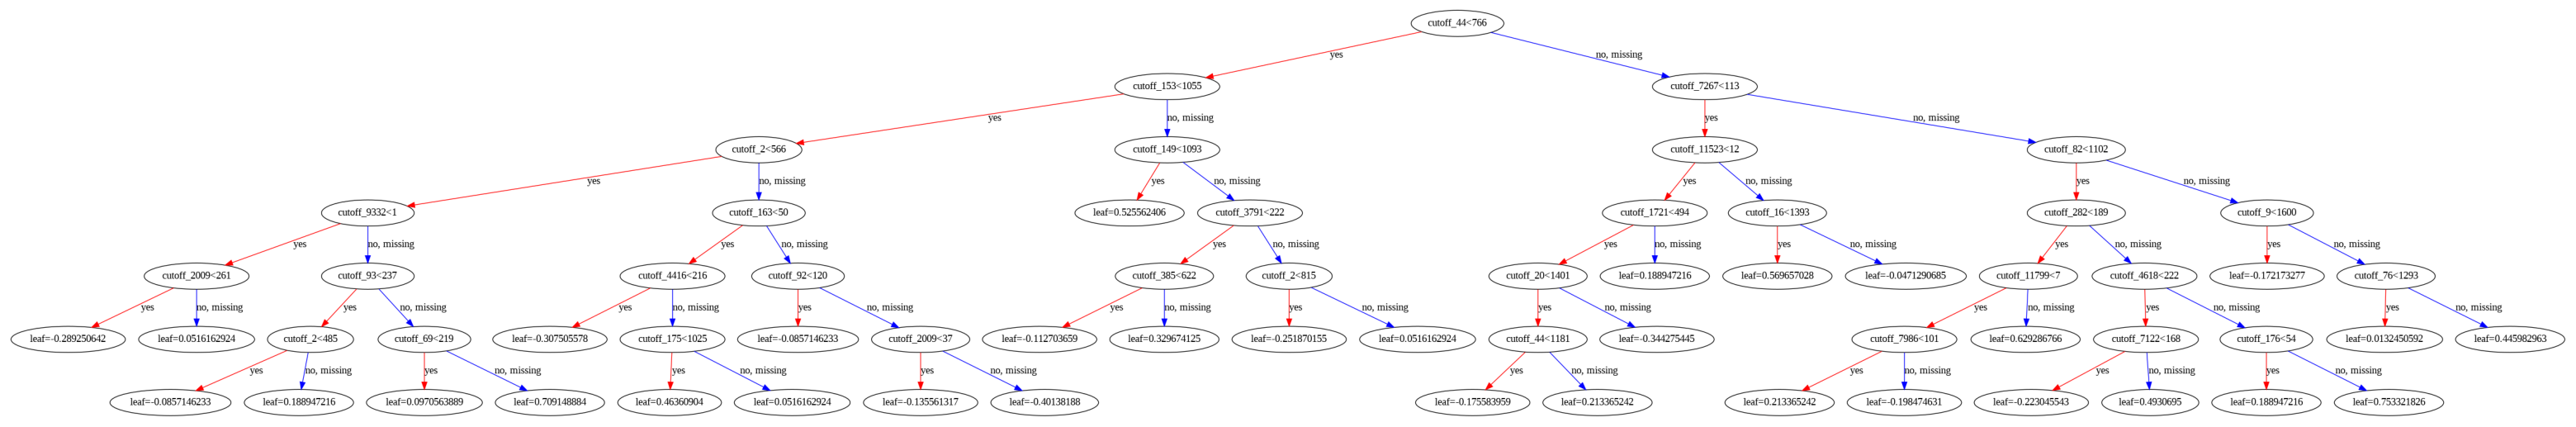

In [ ]:
#Plotting the first XGBoost Tree
plot_tree(GB_AMP_SY_model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(40, 15)

Notice that unlike the Random Forest classifier trees, XGboost trees have by default only 6 levels (counting from below the root node). But To get a better idea of the differences between xgboost trees and the ones from our prior module, we can focus on just one of the sections output below, the one that starts with the Decision threshold <font face="monospace">Cutoff_92 $\leq$ 117.5</font>

![XGBoost-branch.jpg](https://drive.google.com/uc?export=view&id=1ODU_RvhreN2kLCX28UXQckKlMpBxtXwd)
***
**Feature Threshold** (Example: <font face="monospace">Cutoff_92 $\leq$ 117.5</font>)

 This is the same threshold explained in our previous Random Forest Notebook, if the boolean statement is TRUE or "Yes" then it goes to the left leaf, if FALSE or "No" then it goes to the right leaf. Notice that the arrows pointing towards left splits say (**Yes, missing**) This is because XGBoost Trees are also made to include observations that may have missing data for the feature being split on.
***
**Residuals** (Example: <font face="monospace">[r1,r5,r3,r7]</font>)

Eventhough these are not displayed in the original graphed tree from the code, we can imagine how these residuals are classified so we have an idea of how the algorithm works. For the sake of simplifying the explanation, let's imagine that the node with Decision threshold <font face="monospace">Cutoff_92 $\leq$ 117.5</font> has 4 residuals, r1 is the residual for observation 1, r5 for observation 5, so on and so forth. In each of the nodes of an xgboost tree, the residuals for each observation are being classified as we descend on the tree, we have r1 and r5 in the left leaf and r3 and r7 in the right leaf.
***
**Leaf** (Example: <font face="monospace">Leaf=-0.150000006</font>)

For XGboost trees, the leaves do not output the number of observations in each class, instead it displays a decimal, which is known as the **Output value**. This output is computed using only the residuals from the final leaf nodes, which in our pseudoexample would be r1 and r5.  Below its the actual formula to calculate it:

$$Output =\frac{\sum Residuals}{\sum[(Previous \ Probability)*(1-Previous \ Probability)] + \lambda}$$

- *$Residuals$* = The diference between the observed (0 for Resistance and 1 for Susceptibility) and predicted probabilities.

- *$Previous \ Probability$* = These are the probabilities predicted using the prior tree. Since this is an example from the first tree created, the default value for it is 0.5. This number will change as we keep building other trees.

- *$\lambda$*= Is the regularization term, the higher the number the lower the output value. This helps us to not follow too closely any particular observation so that our model generalizes well to new data (bias-variance trade-off). The default is set to 1. There are other regularization coeficcients, in this example *$\lambda$* is equivalent to L2 regularization or Rigde Regression. Here is a [link](https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0#:~:text=Therefore%2C%20the%20L1%20regularization%20decreases,lambda%20term%20increases%20the%20denominator.) for further mathematical explanation if interested.
***

Behind the simple looking XGboost tree there are different metrics used to decide each of the nodes and branches that shape the classifier tree. You can take a peak under the hood of this XGboost tree with the code below and check all the **Gain** and **Cover** scores at each split from the tree we graphed. We will briefly go over these concepts:





In [ ]:
# looking at the metrics for each node of the XGboost classifier Trees
print(GB_AMP_SY_model.get_booster().get_dump(with_stats = True)[0])

0:[cutoff_44<766] yes=1,no=2,missing=2,gain=55.1068649,cover=111.146011
	1:[cutoff_153<1055] yes=3,no=4,missing=4,gain=21.3594761,cover=66.3322525
		3:[cutoff_2<566] yes=7,no=8,missing=8,gain=23.080616,cover=57.6458893
			7:[cutoff_9332<1] yes=15,no=16,missing=16,gain=8.97896194,cover=9.27861881
				15:[cutoff_2009<261] yes=29,no=30,missing=30,gain=1.3845824,cover=3.55351353
					29:leaf=-0.289250642,cover=2.36900902
					30:leaf=0.0516162924,cover=1.18450451
				16:[cutoff_93<237] yes=31,no=32,missing=32,gain=2.85597515,cover=5.72510529
					31:[cutoff_2<485] yes=49,no=50,missing=50,gain=0.877149999,cover=2.36900902
						49:leaf=-0.0857146233,cover=1.18450451
						50:leaf=0.188947216,cover=1.18450451
					32:[cutoff_69<219] yes=51,no=52,missing=52,gain=3.22067928,cover=3.35609627
						51:leaf=0.0970563889,cover=1.57933939
						52:leaf=0.709148884,cover=1.77675676
			8:[cutoff_163<50] yes=17,no=18,missing=18,gain=7.2692337,cover=48.3672676
				17:[cutoff_4416<216] yes=33,no=34,miss

#### **OUTPUT INTERPRETATION of get_dump() for one xgboost Tree**
To interpret each **(root and intermediate)** nodes output, we can take look at the following structure:

<font color="gray">`Parent_node #:[feature threshhold] yes=left_child_#, no=right_child_#, missing=left_child_#, gain=gain, cover=cover`

To interpret each **leaf** nodes output, we can examine the below structure:

<font color="gray">`leaf_node_#:leaf=output_value, cover=cover`
***
For each node in our tree, we calculate the following:

- **Similarity Scores (SS):** The scores indicate how similar are a particular grouping of residuals. This score is important because similar residuals imply similarity in observations, which helps with their classification. Below we can see the formula for SS:

$$\frac{(\sum Residuals)^2}{\sum[(Previous \ Probability)*(1-Previous \ Probability)] + \lambda}$$

<a name="gain-def"></a>
- **Gain:** This is calculated for each of the intermediate nodes and measures the relative contribution of the corresponding feature to the model. The higher this value the better the feature is at making a prediction. Below is the formula:

$$Gain = SS_{(Left)} + SS_{(Right)} - SS_{(Parent \ Node)}$$

- **Cover:** is a metric to measure the number of observations affected by the split. This is essentially if the first part of the denominator in the similarity score:

$$Cover = \sum[(Previous \ Probability)*(1-Previous \ Probability)]$$
***
**NOTE:** When researching this model it's important to know that XGBoost $\neq$ Gradient Boosted Tree. The Reason it has the **Extreme** denomination is that XGBoost builds on Gradient Boosted Tree in that it add different methods of Regularization (to help with generalization of the model and combat overfitting) and parallel processing (increase computing efficiency).


### **6) Making predictions from Gradient Boosted Trees model**

**XGBoost Final Decision Made**

To understand how the final decision is made by the entire XGBoost model, we need to revisit again the equations we learned on the very first ML model we used **Logistic Regression**. Because XGBoost Classifier models uses them as well!

**Logit Equation:** converts probabilities into log-odds predictions.
$$ ln(\frac{P}{1-P}) = \hat \beta_0 + \hat \beta_jX$$

**Logistic Regression Equation:** converts log-odds predictions into probability predictions.
$$P = \frac{e^{\hat{\beta}_{0}+\hat{\beta}_{j}X}}{1+e^{\hat{\beta}_{0}+\hat{\beta}_{j}X}}$$

Turns out these Equations are the ones that enables the XGboost Classifier to convert the predictions made by each of these XGboost Classifier trees into probabilities that will ultimately help us classify our observations into **Resistant (R)** or **Susceptible (S)**. Below we can see a graph of how it works:

![final_pred.jpg](https://drive.google.com/uc?export=view&id=1RbLJnuLNpKsNMCF2gv9YLWZYYaXcmPwQ)

Iteration 1:
**Predicted log (odds1) = Initial Log(odds) + LR * Leaf Output that observation falls into tree 1**

Iteration 2:
**Predicted log (odds2) = Predicted Log(odds1) + LR * Leaf Output that observation falls into tree 2**

ETC...

At the end after we iterate to all xgboost trees (in this case 100 times), at each iteration a new tree is added and each time the predicted log (odds) gets updated with a better aproximation until we get a final **Predicted log (odds100)**, which takes in consideration a total of 100 trees. This final prediction is converted to a probability using the logit and logistic regression equations. This should give us the final prediction of **Resistant (R) if probability < 0.5** or **Susceptible (S) if probability > 0.5**

**NOTE:** The Learning Rate in XGBoost is also called **"eta"** in other sources.
***

Below we can run a short piece of code to check the improvements for every 10 iterations out of a total of 100 to test how an XGBoost model works, we are not actually using our own model, the code creates automatically a training and validation sets, from the training data:

In [ ]:
# creates a copy of the labels
num_labels = AMP_Train_test_dic['labels_train'].copy()

# transforms all labels of S into 1 and all labels of R into 0
num_labels.loc[num_labels == "S"] = 1.0
num_labels.loc[num_labels == "R"] = 0.0

# create a matrix using the only the training data and the training labels coded as numbers
d = xgb.DMatrix(AMP_SY_train_df, label=num_labels)

# set up basic parameters that are similar to our model
p = {'max_depth':6, 'eta':0.33, 'objective':'binary:logistic'}

# prints results for every 10 iterations out of 100
res = xgb.cv(params = p, dtrain=d, num_boost_round=100, verbose_eval=10, metrics="error")

[0]	train-error:0.25222+0.00157	test-error:0.25223+0.00315
[10]	train-error:0.01865+0.00577	test-error:0.23619+0.02511
[20]	train-error:0.00089+0.00125	test-error:0.25040+0.02123
[30]	train-error:0.00000+0.00000	test-error:0.23267+0.02456
[40]	train-error:0.00000+0.00000	test-error:0.23448+0.02319
[50]	train-error:0.00000+0.00000	test-error:0.23269+0.02396
[60]	train-error:0.00000+0.00000	test-error:0.23448+0.01918
[70]	train-error:0.00000+0.00000	test-error:0.23980+0.02428
[80]	train-error:0.00000+0.00000	test-error:0.22914+0.02002
[90]	train-error:0.00000+0.00000	test-error:0.23448+0.02319
[99]	train-error:0.00000+0.00000	test-error:0.23448+0.02730


The code above shows us that the overall trend is that the error rate decreases as number of iteration increases. The outputs are composed of 2 numbers in the following format:

`train-error: #1 + #2     test-error: #1 + #2`

- **#1** is the error shown for training and testing sets, it is essentially (1- accuracy) for each 10th iteration.
- **#2** is the standard deviation of the error rates.


Now that we have an idea of how the XGBoost tree trains and makes its final predictions using all the trees. We can now make predictions with it, below a simple function is created similar to the code in the previous notebook:

In [ ]:
def predict(GB_combo_Model, features_test):
  labels_pred = GB_combo_Model.predict(features_test)
  return labels_pred

In [ ]:
# Implementing combo_feat() function created for testing data
AMP_SY_test_df = combo_feat(AMP_Train_test_dic['features_test'],"AMP","SY")

# looking only at the feature column names for the combination for "SY" for drug "AMP" for testing data
AMP_SY_test_df.columns

Index(['cutoff_2', 'cutoff_3', 'cutoff_4', 'cutoff_5', 'cutoff_6', 'cutoff_7',
       'cutoff_8', 'cutoff_9', 'cutoff_10', 'cutoff_11',
       ...
       'Year_2007.0', 'Year_2008.0', 'Year_2009.0', 'Year_2010.0',
       'Year_2011.0', 'Year_2012.0', 'Year_2013.0', 'Year_2014.0',
       'Year_2015.0', 'Year_2017.0'],
      dtype='object', length=1093)

In [ ]:
# Implementation of the predict() function using the feature combination "GS"
AMP_SY_labels_pred = predict(GB_AMP_SY_model,AMP_SY_test_df)

# transforming back our labels for interpretation in the next output
labels_pred = np.where(AMP_SY_labels_pred<1,"R","S")

# observe how many predictions were made for each category "R" and "S"
print("Labels predicted: ", np.unique(labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype='<U1'), array([215,  63]))


### **7) Evaluating our model using a confusion matrix and metrics**

Similarly to the previous notebook, we will evaluate our XGBoost model by using a Confusion Matrix and respective metrics. Below is a quick review of these, remember that there is one Accuracy score, but Recall and Presicion should have as many sets as classes our model its trained to predict:

|<font size=3>Metrics|<font size=3>General formula| <font size=3>Formula for 2 classes|
|--|:-:|:-:
|<font size=3>**Accuracy**|<font size=3>$\frac{Correctly \ classified}{All \ Predicted}$|<font size=3>$\frac{TP + TN}{TP + TN + FN + FP}$|
|<font size=3>**R Recall:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Actual \ R}$|<font size=3>$\frac{TP}{TP + FN}$|
|<font size=3>**R Precision:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Predicted \ R}$|<font size=3>$\frac{TP}{TP + FP}$|

**NOTE:** Code below is the same as in previous notebook


In [ ]:
# Creating a function that evaluates our model using our actual and predicted data
def evaluate(GB_combo_model, labels_test, labels_pred, cf= True, show_results=True):
  labels = labels_test
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_t = le.transform(labels)
  report = classification_report(labels_t, labels_pred, output_dict = True)
  if cf == True:
    labels_pred = np.where(labels_pred<1,"R","S")
    cm = confusion_matrix(labels_test, labels_pred, labels=np.where(GB_combo_model.classes_<1,"R","S"))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.where(GB_combo_model.classes_<1,"R","S"))
    disp.plot()
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',report['accuracy'])
    print('R recall:',report['0']['recall'])
    print('S recall:',report['1']['recall'])
    print('R precision:',report['0']['precision'])
    print('S precision:',report['1']['precision'])
  return [report['accuracy'], report['0']['recall'], report['1']['recall'], report['0']['precision'], report['1']['precision']]

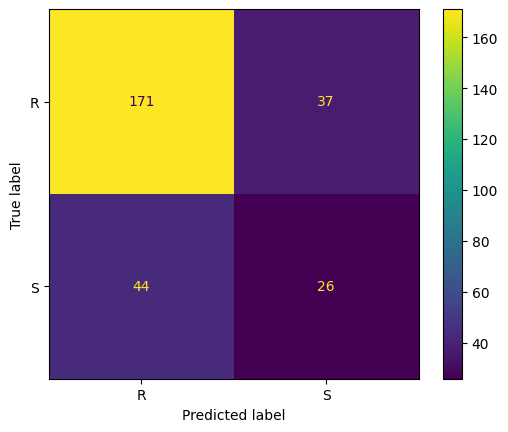

Results
Accuracy: 0.7086330935251799
R recall: 0.8221153846153846
S recall: 0.37142857142857144
R precision: 0.7953488372093023
S precision: 0.4126984126984127


In [ ]:
# implementing the evaluate() function
Model_Report = evaluate(GB_AMP_SY_model, AMP_Train_test_dic['labels_test'],AMP_SY_labels_pred)

**b) Create a feature importance graph showing which features were the most important**

There are actually different ways to evaluate the importance of features in this model, some are based on the **Cover**, others in **Gain**, etc. Since we are already familiar with how these are calculated in [Part 5](#gain-def).

The plot below will focus on the **Gain**. Since every node in every tree of our XGBoost model have their own gain, the value shown is just the average of each node. The Gain is the most relevant attribute to interpret the relative importance of each feature.

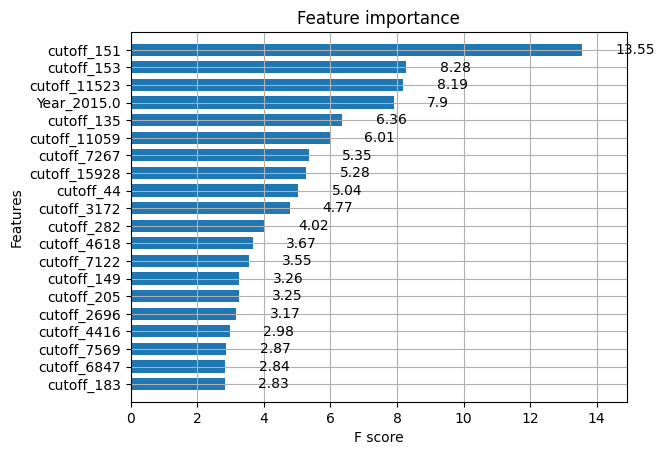

In [ ]:
# Plotting feature importance ("gain")
feat_imp = GB_AMP_SY_model.get_booster().get_score(importance_type="gain")
for k in feat_imp.keys():
    feat_imp[k] = round(feat_imp[k],2)

plot_importance(feat_imp, max_num_features = 20, importance_type = "gain", show_values=True, height=0.7)
plt.savefig('/content/drive/My Drive/EColi_ML_Plots/XGBoost_AMP_SY_feat_importance.jpg',dpi=400, bbox_inches="tight")

Below we can see that the most important feature in the model **GB_AMP_SY_model**, based in **Gain** metric is `cutoff_11059`.
The Gain implies the relative contribution of the feature to the model. It takes each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

### **8) Use all functions and evaluate every drug in every feature combination!**
**NOTE:** Code below is the same as in previous notebook

#### **a) Lets recall the list of drugs we have available and the combination of features we are interested in**

In [ ]:
# let's check all drugs
drug_list = All_Drugs_df.iloc[:,1:13].columns
print(drug_list)

# let's see all combinations we are interested in
print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['G', 'S', 'GY', 'SY', 'GS', 'GYS']


#### **b) Create a loop that will go through all our functions using the lists above**

In [ ]:
# Lets use all our functions this time and save our report into a single data structure
GB_model_metrics = {}

for drug in drug_list:
  print(drug)
  Test_Train_dic = Split_train_test(drug)
  for combo in combo_list:
    # Training each drug_combo features
    labels_train = Test_Train_dic["labels_train"]
    features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)
    GB_combo_model = run_GB(features_train, labels_train, drug, combo)

    # Predicting each drug_combo features
    features_test = combo_feat(Test_Train_dic["features_test"], drug, combo)
    labels_pred = predict(GB_combo_model, features_test)

    # Evaluating our models
    labels_test = Test_Train_dic["labels_test"]
    report = evaluate(GB_combo_model, labels_test, labels_pred, cf=False, show_results=False)
    GB_model_metrics[drug+"_"+combo] = report

    print(report)

CTZ
CTZ Training combo: G
Number of Decicion Trees in XGB Classifier model: None
[0.9499217527386542, 0.7272727272727273, 0.985480943738657, 0.8888888888888888, 0.9576719576719577]
CTZ Training combo: S
Number of Decicion Trees in XGB Classifier model: None
[0.8998435054773083, 0.48863636363636365, 0.9655172413793104, 0.6935483870967742, 0.9220103986135182]
CTZ Training combo: GY
Number of Decicion Trees in XGB Classifier model: None
[0.9530516431924883, 0.7386363636363636, 0.9872958257713249, 0.9027777777777778, 0.9594356261022927]
CTZ Training combo: SY
Number of Decicion Trees in XGB Classifier model: None
[0.9076682316118936, 0.5340909090909091, 0.9673321234119783, 0.7230769230769231, 0.9285714285714286]
CTZ Training combo: GS
Number of Decicion Trees in XGB Classifier model: None
[0.9483568075117371, 0.7386363636363636, 0.9818511796733213, 0.8666666666666667, 0.9592198581560284]
CTZ Training combo: GYS
Number of Decicion Trees in XGB Classifier model: None
[0.9483568075117371, 0.7

#### **c) Store the metrics report for all drugs and features combinations as a csv file**

In [ ]:
# convert dictionary into a dataframe
GB_metrics = pd.DataFrame.from_dict(GB_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
GB_metrics = GB_metrics.rename(columns = {'index':'Drug_combo'})

# saving our metric results into a CSV file
GB_metrics.to_csv(filepath+"GB_metrics_df.csv", index= False)
GB_metrics


,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision
0,CTZ_G,0.949922,0.727273,0.985481,0.888889,0.957672
1,CTZ_S,0.899844,0.488636,0.965517,0.693548,0.922010
2,CTZ_GY,0.953052,0.738636,0.987296,0.902778,0.959436
3,CTZ_SY,0.907668,0.534091,0.967332,0.723077,0.928571
4,CTZ_GS,0.948357,0.738636,0.981851,0.866667,0.959220
...,...,...,...,...,...,...
67,CIP_S,0.926448,0.802817,0.961771,0.857143,0.944664
68,CIP_GY,0.943662,0.838028,0.973843,0.901515,0.954635
69,CIP_SY,0.926448,0.802817,0.961771,0.857143,0.944664
70,CIP_GS,0.946792,0.852113,0.973843,0.902985,0.958416


We have finally created and saved all the XGBoost Classifier results for every antibiotic and combination of features we were interested in. Next we will be moving away from tree-based or ensemble methods and learn about our last Machine Learning Method: [Neural Networks](https://colab.research.google.com/drive/1uxBtrr3F4r35ov9-AUswQS-WIWAO3TsU?usp=sharing).